In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset 1: Bird clif

In [ ]:
base_path_clief = "/content/drive/MyDrive/bird-dataset"
import pandas as pd
import shutil

metadata_path = f"{base_path_clief}/train_metadata.csv"
taxonomy_path = f"{base_path_clief}/eBird_Taxonomy_v2021.csv"

metadata = pd.read_csv(metadata_path)
taxonomy = pd.read_csv(taxonomy_path)

metadata_peru = metadata[
    (metadata['latitude'] >= -19.0) & (metadata['latitude'] <= -0.1) &
    (metadata['longitude'] >= -81.5) & (metadata['longitude'] <= -68.0)
]

especies_codigos_peru = metadata_peru['primary_label'].unique()

especies_peruanas = taxonomy[taxonomy['SPECIES_CODE'].isin(especies_codigos_peru)]

print("\n Especies peruanas en BirdCLEF:")
print(especies_peruanas[['SPECIES_CODE', 'PRIMARY_COM_NAME', 'SCI_NAME']].head(30))

import os

direct_base = f"{base_path_clief}/train_audio"

especies_validas = []

for code in especies_peruanas['SPECIES_CODE']:
    especie_path = os.path.join(direct_base, code)
    if os.path.isdir(especie_path):
        num_archivos = len([f for f in os.listdir(especie_path) if f.lower().endswith('.ogg')])
        if num_archivos >= 70:
            especies_validas.append((code, num_archivos))

print(f"\n Especies peruanas con al menos 50 audios en BirdCLEF:")
for code, count in sorted(especies_validas, key=lambda x: x[1], reverse=True):
    print(f"  - {code}: {count} audios")

direct_final = "/content/drive/MyDrive/dataset_final"
os.makedirs(direct_final, exist_ok=True)

mapa_codigo_nombre = dict(zip(taxonomy['SPECIES_CODE'], taxonomy['SCI_NAME']))

for code, _ in especies_validas:
    nombre_cientifico = mapa_codigo_nombre.get(code)
    if not nombre_cientifico:
        print(f" Código no encontrado en taxonomía: {code}")
        continue

    origen = os.path.join(direct_base, code)
    destino = os.path.join(direct_final, nombre_cientifico)
    os.makedirs(destino, exist_ok=True)

    archivos = [f for f in os.listdir(origen) if f.endswith('.ogg')][:70]
    for i, archivo in enumerate(archivos):
        origen_archivo = os.path.join(origen, archivo)
        nuevo_nombre = f"birdclef_{i+1:03}.ogg"
        destino_archivo = os.path.join(destino, nuevo_nombre)
        shutil.copy2(origen_archivo, destino_archivo)

    print(f" Copiados {len(archivos)} audios de {nombre_cientifico}")

print("\n Copia desde BirdCLEF completada.")


Dataset 2: Xeno canto

In [ ]:
import os

def imprimir_especies_validas(base_dir, min_audios=70):
    print(f"\nEspecies peruanas con al menos {min_audios} audios en Xeno-Canto:")
    for especie in sorted(os.listdir(base_dir)):
        especie_path = os.path.join(base_dir, especie)
        if os.path.isdir(especie_path):
            count = len([f for f in os.listdir(especie_path) if f.lower().endswith('.mp3')])
            if count >= min_audios:
                print(f"  - {especie}: {count} audios")

# Uso
imprimir_especies_validas("xeno-canto-download/dataset/audio", min_audios=70)

import os
import shutil

def copiar_especies_validas_xeno(base_dir, min_audios=70, direct_final="dataset_final"):
    print(f"\nEspecies peruanas con al menos {min_audios} audios en Xeno-Canto:")
    for especie in sorted(os.listdir(base_dir)):
        especie_path = os.path.join(base_dir, especie)
        if os.path.isdir(especie_path):
            archivos = [f for f in os.listdir(especie_path) if f.lower().endswith('.mp3')]
            if len(archivos) >= min_audios:
                print(f"  - {especie}: {len(archivos)} audios")

                # Crear carpeta destino
                # Normalizar nombre: guiones bajos en espacios y capitalizar
                nombre_normalizado = especie.replace("-", " ").replace("'", " ").title()
                destino = os.path.join(direct_final, nombre_normalizado)

                os.makedirs(destino, exist_ok=True)


                for i, archivo in enumerate(archivos[:70]):
                    origen_archivo = os.path.join(especie_path, archivo)
                    nuevo_nombre = f"xeno_{i+1:03}.mp3"
                    destino_archivo = os.path.join(destino, nuevo_nombre)
                    shutil.copy2(origen_archivo, destino_archivo)

                print(f"     Copiados {min(70, len(archivos))} audios a: {destino}")


copiar_especies_validas_xeno("xeno-canto-download/dataset/audio", min_audios=70)


In [ ]:
!pip install audiomentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.11.0
    Uninstalling librosa-0.11.0:
      Successfully uninstalled librosa-0.11.0


Augmentacion

In [ ]:
import os
import librosa
import soundfile as sf
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift
import random

# Rutas
ORIGEN = "/content/drive/MyDrive/dataset_final"
DESTINO = "/content/drive/MyDrive/dataset_augmented"
os.makedirs(DESTINO, exist_ok=True)

# Aumentaciones disponibles
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.9, max_rate=1.1, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5)
])

# Configuración
AUMENTOS_POR_AUDIO = 2  # versiones a generar por audio

# Recorre cada especie
for especie in os.listdir(ORIGEN):
    ruta_especie = os.path.join(ORIGEN, especie)
    if not os.path.isdir(ruta_especie):
        continue

    destino_especie = os.path.join(DESTINO, especie)
    os.makedirs(destino_especie, exist_ok=True)

    for archivo in os.listdir(ruta_especie):
        if archivo.endswith(".mp3") or archivo.endswith(".ogg"):
            ruta_audio = os.path.join(ruta_especie, archivo)
            try:
                audio, sr = librosa.load(ruta_audio, sr=16000)

                nombre_base = os.path.splitext(archivo)[0]
                sf.write(os.path.join(destino_especie, f"{nombre_base}_orig.wav"), audio, sr)

                for i in range(AUMENTOS_POR_AUDIO):
                    audio_aug = augment(samples=audio, sample_rate=sr)
                    nombre_aug = f"{nombre_base}_aug{i+1}.wav"
                    sf.write(os.path.join(destino_especie, nombre_aug), audio_aug, sr)

            except Exception as e:
                print(f" Error con {archivo}: {e}")

print("\nAumentación completada. Audios guardados en 'dataset_augmented/'")



Aumentación completada. Audios guardados en 'dataset_augmented/'


Extraccion de embeddings

In [ ]:
!pip install tensorflow_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 599.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


In [ ]:
import os
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
import librosa

CARPETA_AUDIO = "/content/drive/MyDrive/dataset_augmented"
DESTINO = "/content/drive/MyDrive/embeddings_yamnet"
os.makedirs(DESTINO, exist_ok=True)


yamnet = hub.load("https://tfhub.dev/google/yamnet/1")


def procesar_audio(ruta_audio):
    audio, sr = librosa.load(ruta_audio, sr=16000)
    audio = tf.convert_to_tensor(audio, dtype=tf.float32)
    _, embeddings, _ = yamnet(audio)
    return embeddings.numpy().mean(axis=0)

for especie in os.listdir(CARPETA_AUDIO):
    ruta_especie = os.path.join(CARPETA_AUDIO, especie)
    if not os.path.isdir(ruta_especie):
        continue

    destino_especie = os.path.join(DESTINO, especie)
    os.makedirs(destino_especie, exist_ok=True)

    for archivo in os.listdir(ruta_especie):
        if archivo.endswith(".mp3") or archivo.endswith(".ogg") or archivo.endswith(".wav"):
            ruta_audio = os.path.join(ruta_especie, archivo)
            try:
                emb = procesar_audio(ruta_audio)
                nombre_salida = archivo.replace(".mp3", ".npy").replace(".ogg", ".npy").replace(".wav", ".npy")
                np.save(os.path.join(destino_especie, nombre_salida), emb)
            except Exception as e:
                print(f" Error con {ruta_audio}: {e}")

print("\n Extracción completada. Embeddings guardados en 'embeddings_yamnet/'")



 Extracción completada. Embeddings guardados en 'embeddings_yamnet/'


# Prueba de modelos

## **Carga de los datos de entrenamiento**

In [ ]:
!pip install tensorflow

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def cargar_embeddings_yamnet(path):
    X, y, clases = [], [], sorted(os.listdir(path))
    clase_a_idx = {clase: idx for idx, clase in enumerate(clases)}
    for clase in clases:
        carpeta = os.path.join(path, clase)
        for archivo in os.listdir(carpeta):
            if archivo.endswith(".npy"):
                vector = np.load(os.path.join(carpeta, archivo))
                X.append(vector)
                y.append(clase_a_idx[clase])
    X = np.array(X)
    y = tf.keras.utils.to_categorical(y, num_classes=len(clases))
    return X, y, clases

# === Cargar datos ===
X, y, clases = cargar_embeddings_yamnet("/content/drive/MyDrive/embeddings_yamnet")
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [ ]:
print(clases)

['Ardea alba', 'Azara Sspinetail', 'Black Facedantbird', 'Bubulcus ibis', 'Butorides striata', 'Grey Breastedwoodwren', 'Housewren', 'Southernchestnut Tailedantbird', 'White Browedantbird']


## **Función de entrenamiento y evaluación para cada modelo**

In [ ]:
def entrenar_y_evaluar(nombre, modelo):
    modelo.fit(X_train, y_train, validation_data=(X_val, y_val),
               epochs=30, batch_size=32,
               callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
               verbose=1)

    loss, acc = modelo.evaluate(X_test, y_test, verbose=0)
    y_pred = modelo.predict(X_test, verbose=0)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    f1 = f1_score(y_true, y_pred_labels, average='macro')

    resultados.append({"Variante": nombre, "Accuracy": acc, "F1_macro": f1})

    mostrar_matriz_confusion(y_true, y_pred_labels, clases, nombre)

    print(f"\n=== Classification Report: {nombre} ===")
    print(classification_report(y_true, y_pred_labels, target_names=clases))

resultados = []

## **Observar la matriz de confusión para cada modelo**

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def mostrar_matriz_confusion(y_true, y_pred, clases, nombre):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=clases, yticklabels=clases)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.tight_layout()
    plt.show()

## **Modelo base**

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2394 - loss: 2.0806 - val_accuracy: 0.4558 - val_loss: 1.6772
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4580 - loss: 1.6430 - val_accuracy: 0.5523 - val_loss: 1.5176
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5135 - loss: 1.4967 - val_accuracy: 0.5845 - val_loss: 1.4523
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5694 - loss: 1.4316 - val_accuracy: 0.6166 - val_loss: 1.3821
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6201 - loss: 1.3364 - val_accuracy: 0.6086 - val_loss: 1.3573
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6255 - loss: 1.3362 - val_accuracy: 0.6381 - val_loss: 1.3152
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6654 - loss: 1.2784 - val_accuracy: 0.6622 - val_loss: 1.2977
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6665 - loss: 1.2389 - val_accuracy: 0.6702 - val_loss

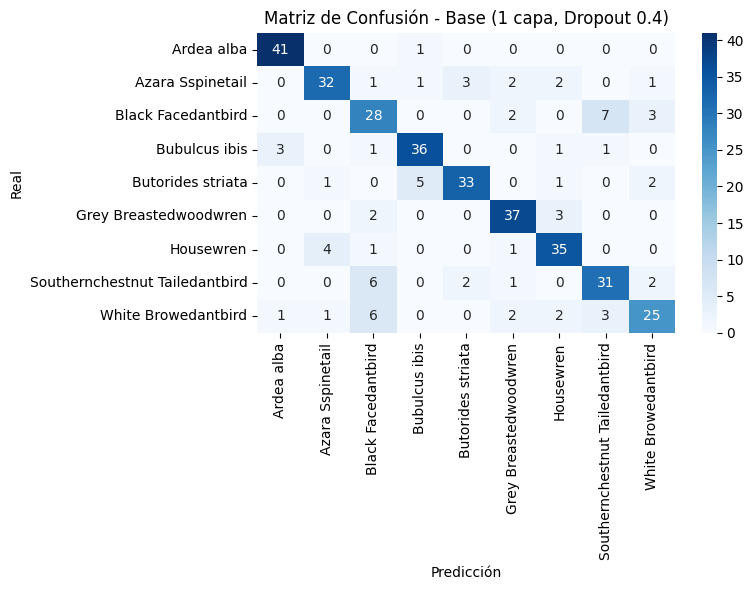


=== Classification Report: Base (1 capa, Dropout 0.4) ===
                                precision    recall  f1-score   support

                    Ardea alba       0.91      0.98      0.94        42
              Azara Sspinetail       0.84      0.76      0.80        42
            Black Facedantbird       0.62      0.70      0.66        40
                 Bubulcus ibis       0.84      0.86      0.85        42
             Butorides striata       0.87      0.79      0.82        42
         Grey Breastedwoodwren       0.82      0.88      0.85        42
                     Housewren       0.80      0.85      0.82        41
Southernchestnut Tailedantbird       0.74      0.74      0.74        42
           White Browedantbird       0.76      0.62      0.68        40

                      accuracy                           0.80       373
                     macro avg       0.80      0.80      0.80       373
                  weighted avg       0.80      0.80      0.80       373



In [ ]:
modelo_base = models.Sequential([
    layers.Input(shape=(1024,)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(clases), activation='softmax')
])
modelo_base.compile(optimizer='adam',
                    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
                    metrics=['accuracy'])
entrenar_y_evaluar("Base (1 capa, Dropout 0.4)", modelo_base)

## **Modelo 2**

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2426 - loss: 2.0561 - val_accuracy: 0.4370 - val_loss: 1.4716
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4256 - loss: 1.4553 - val_accuracy: 0.4960 - val_loss: 1.3148
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5096 - loss: 1.3027 - val_accuracy: 0.5684 - val_loss: 1.1703
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5821 - loss: 1.1454 - val_accuracy: 0.5925 - val_loss: 1.0963
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6030 - loss: 1.0824 - val_accuracy: 0.6890 - val_loss: 0.9078
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6772 - loss: 0.8628 - val_accuracy: 0.6649 - val_loss: 0.9806
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7050 - loss: 0.8368 - val_accuracy: 0.6649 - val_loss: 0.9063
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7063 - loss: 0.7857 - val_accuracy: 0.6783 - val_los

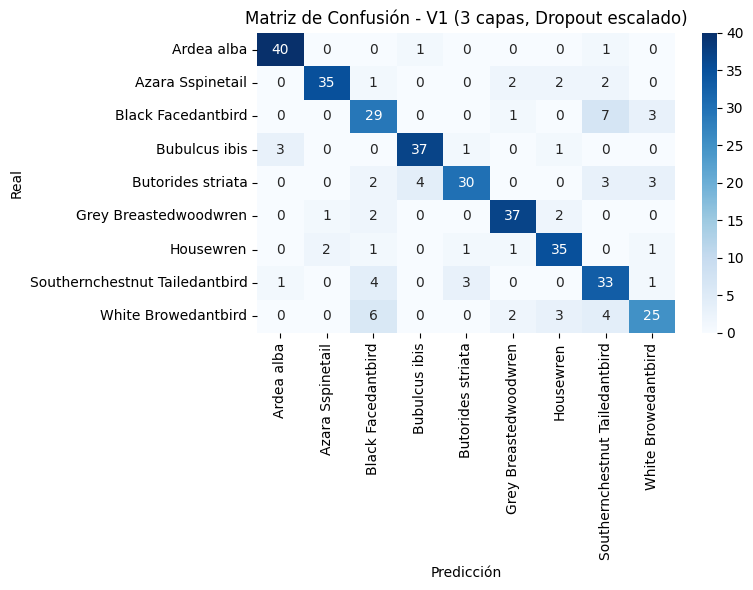


=== Classification Report: V1 (3 capas, Dropout escalado) ===
                                precision    recall  f1-score   support

                    Ardea alba       0.91      0.95      0.93        42
              Azara Sspinetail       0.92      0.83      0.88        42
            Black Facedantbird       0.64      0.72      0.68        40
                 Bubulcus ibis       0.88      0.88      0.88        42
             Butorides striata       0.86      0.71      0.78        42
         Grey Breastedwoodwren       0.86      0.88      0.87        42
                     Housewren       0.81      0.85      0.83        41
Southernchestnut Tailedantbird       0.66      0.79      0.72        42
           White Browedantbird       0.76      0.62      0.68        40

                      accuracy                           0.81       373
                     macro avg       0.81      0.81      0.81       373
                  weighted avg       0.81      0.81      0.81       373

In [ ]:
modelo_v1 = models.Sequential([
    layers.Input(shape=(1024,)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(384, activation='relu'),
    layers.Dropout(0.20),
    layers.Dense(192, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(len(clases), activation='softmax')
])
modelo_v1.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
entrenar_y_evaluar("V1 (3 capas, Dropout escalado)", modelo_v1)

## **Modelo 3**

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.2678 - loss: 2.4028 - val_accuracy: 0.3619 - val_loss: 1.9553
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4868 - loss: 1.5638 - val_accuracy: 0.4021 - val_loss: 1.8096
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5585 - loss: 1.2363 - val_accuracy: 0.4692 - val_loss: 1.6563
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5834 - loss: 1.1560 - val_accuracy: 0.5013 - val_loss: 1.5626
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6285 - loss: 1.0956 - val_accuracy: 0.5764 - val_loss: 1.4044
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6515 - loss: 1.0462 - val_accuracy: 0.6381 - val_loss: 1.2662
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7098 - loss: 0.8632 - val_accuracy: 0.6300 - val_loss: 1.2060
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7167 - loss: 0.8910 - val_accuracy: 0.6917 - val_lo

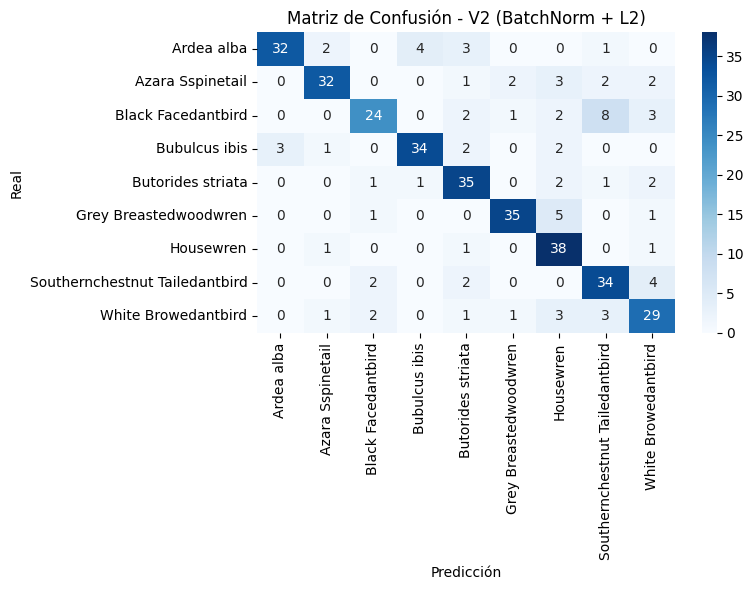


=== Classification Report: V2 (BatchNorm + L2) ===
                                precision    recall  f1-score   support

                    Ardea alba       0.91      0.76      0.83        42
              Azara Sspinetail       0.86      0.76      0.81        42
            Black Facedantbird       0.80      0.60      0.69        40
                 Bubulcus ibis       0.87      0.81      0.84        42
             Butorides striata       0.74      0.83      0.79        42
         Grey Breastedwoodwren       0.90      0.83      0.86        42
                     Housewren       0.69      0.93      0.79        41
Southernchestnut Tailedantbird       0.69      0.81      0.75        42
           White Browedantbird       0.69      0.72      0.71        40

                      accuracy                           0.79       373
                     macro avg       0.80      0.78      0.78       373
                  weighted avg       0.80      0.79      0.79       373



In [ ]:
modelo_v2 = models.Sequential([
    layers.Input(shape=(1024,)),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(len(clases), activation='softmax')
])
modelo_v2.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
entrenar_y_evaluar("V2 (BatchNorm + L2)", modelo_v2)

## **Modelo 4**

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.2505 - loss: 2.0342 - val_accuracy: 0.4424 - val_loss: 1.5303
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4461 - loss: 1.5235 - val_accuracy: 0.5201 - val_loss: 1.3401
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5088 - loss: 1.3232 - val_accuracy: 0.5335 - val_loss: 1.2557
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5512 - loss: 1.2337 - val_accuracy: 0.5496 - val_loss: 1.1777
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5699 - loss: 1.1425 - val_accuracy: 0.6059 - val_loss: 1.0537
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6089 - loss: 1.1045 - val_accuracy: 0.6408 - val_loss: 1.0191
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6142 - loss: 1.1111 - val_accuracy: 0.6488 - val_loss: 0.9924
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6477 - loss: 1.0035 - val_accuracy: 0.6461 - val_l

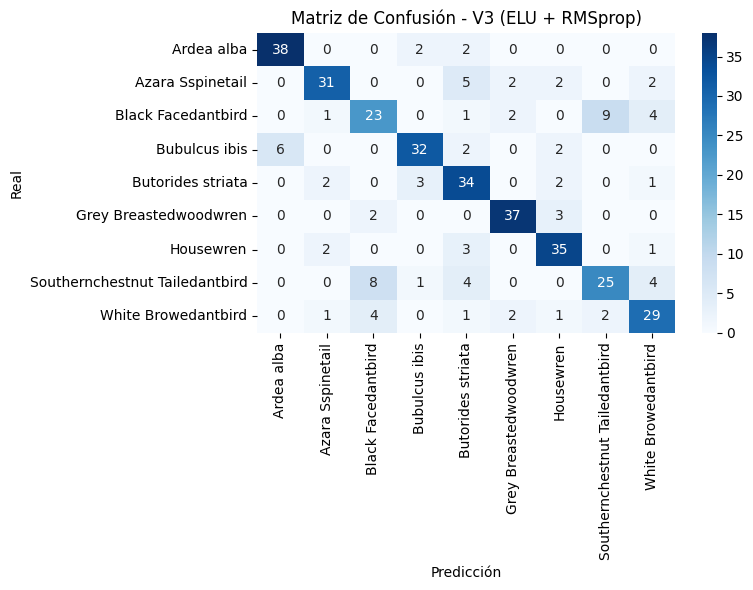


=== Classification Report: V3 (ELU + RMSprop) ===
                                precision    recall  f1-score   support

                    Ardea alba       0.86      0.90      0.88        42
              Azara Sspinetail       0.84      0.74      0.78        42
            Black Facedantbird       0.62      0.57      0.60        40
                 Bubulcus ibis       0.84      0.76      0.80        42
             Butorides striata       0.65      0.81      0.72        42
         Grey Breastedwoodwren       0.86      0.88      0.87        42
                     Housewren       0.78      0.85      0.81        41
Southernchestnut Tailedantbird       0.69      0.60      0.64        42
           White Browedantbird       0.71      0.72      0.72        40

                      accuracy                           0.76       373
                     macro avg       0.76      0.76      0.76       373
                  weighted avg       0.76      0.76      0.76       373



In [ ]:
modelo_v3 = models.Sequential([
    layers.Input(shape=(1024,)),
    layers.Dense(128, activation='elu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='elu'),
    layers.Dropout(0.3),
    layers.Dense(len(clases), activation='softmax')
])
modelo_v3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
entrenar_y_evaluar("V3 (ELU + RMSprop)", modelo_v3)

## **Comparación de resultados**

In [ ]:
df_resultados = pd.DataFrame(resultados)
print("\nResultados comparativos:\n", df_resultados)


Resultados comparativos:
                          Variante  Accuracy  F1_macro
0      Base (1 capa, Dropout 0.4)  0.798928  0.796727
1  V1 (3 capas, Dropout escalado)  0.806971  0.806000
2             V2 (BatchNorm + L2)  0.785523  0.784830
3              V3 (ELU + RMSprop)  0.761394  0.758995


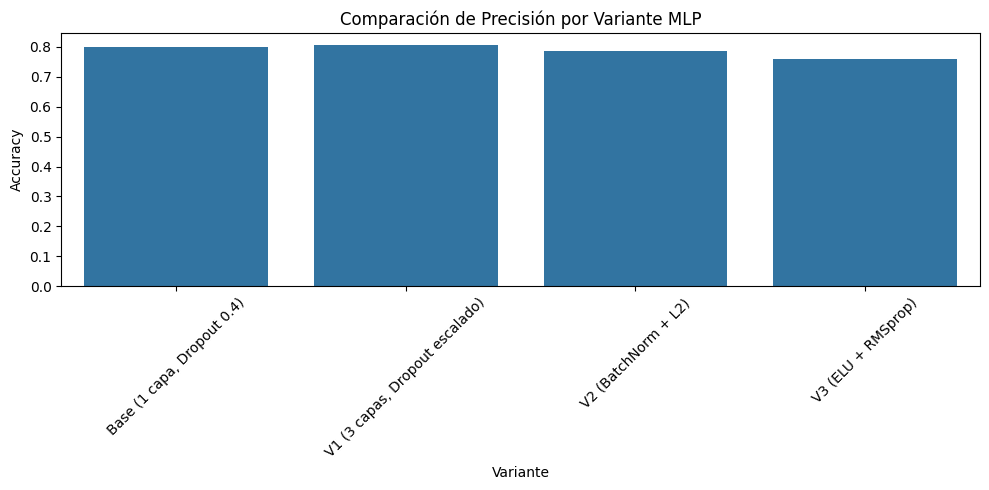

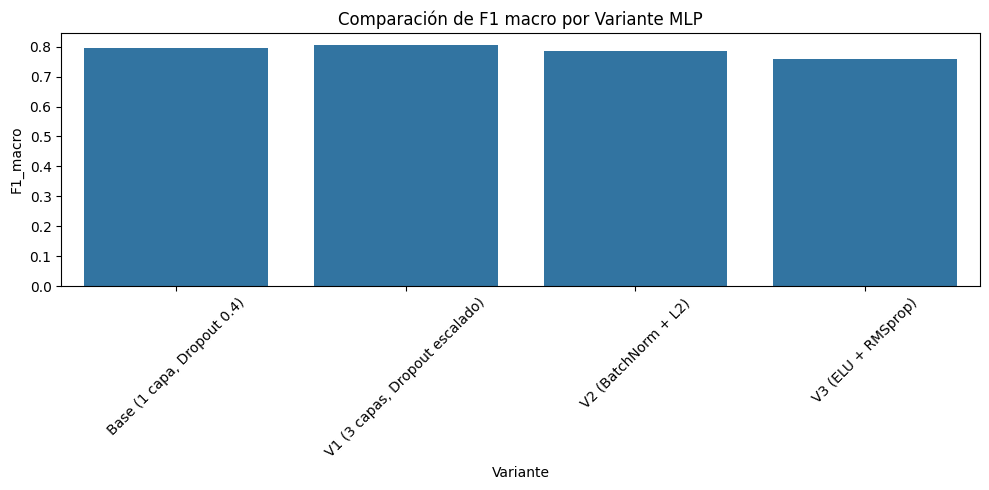

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_resultados, x="Variante", y="Accuracy")
plt.title("Comparación de Precisión por Variante MLP")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=df_resultados, x="Variante", y="F1_macro")
plt.title("Comparación de F1 macro por Variante MLP")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
modelo_v1.save("modelo_yamnet.h5")

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from tensorflow.keras.models import load_model
import numpy as np
import io


modelo_cargado = load_model("modelo_yamnet.h5")

lista_clases = clases

archivo = widgets.FileUpload(
    accept='.npy',
    multiple=False
)

boton_predecir = widgets.Button(description="Predecir clase")

salida = widgets.Output()

def predecir_clase(b):
    salida.clear_output()
    if archivo.value:
        nombre_archivo = list(archivo.value.keys())[0]
        contenido = archivo.value[nombre_archivo]['content']
        vector = np.load(io.BytesIO(contenido), allow_pickle=True)
        if vector.shape != (1024,):
            with salida:
                print("Error: el archivo no contiene un embedding YAMNet válido.")
            return
        vector = np.expand_dims(vector, axis=0)
        pred = modelo_cargado.predict(vector)
        clase_predicha = lista_clases[np.argmax(pred)]
        with salida:
            print(f"Clase predicha: {clase_predicha}")
    else:
        with salida:
            print("Por favor, sube un archivo .npy")

boton_predecir.on_click(predecir_clase)

display(widgets.VBox([archivo, boton_predecir, salida]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
